In [1]:
import tables
import pandas as pd
import numpy as np
import h5py
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy import stats
from iminuit import Minuit
import math
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import emcee
from scipy.constants import c
from scipy.special import erf
from scipy.stats import hypsecant
from scipy.stats import norm
from scipy.stats import laplace

from scipy.integrate import quad

from colossus.cosmology import cosmology
from colossus.lss import peaks
from colossus.halo import mass_so
from colossus.halo import concentration

from intergrid.intergrid import Intergrid
%load_ext cython

# This notebooks demonstrates how I am making and plotting the fit to the infalling population.

It will:

* Fit the infalling model of \sigma to data
* Assign a $\sigma_i$ to each galaxy using the best fit parameters
* Bin the data by radial distance. Plot the mean value of $\sigma_i$/v_{c,i} in each bin. This is the line of my graph.

And, separately
* Bin the data by radial distance. Fit $v/v_{circ}$ in that bin to a hypsecant. Report out the value and error in the scale parameter estimate. These are the data points of my graph.

At the end, I produce a plot that compares what the model thinks the mean of the normalized $\sigma_i$ is in that bin to what you'd get if you just fit the normalized velocities in that bin to a hypsecant.

Throughout, I will use $R_{edge} = 2\rm{R_{200m}}$.

# Prepare the data. I am partial to pandas.

In [2]:
# new../
# old ./
for i in tqdm(range(50)):
    filename='../Downloads/UM_2d-20220418T173722Z-001/UM_2d/new_mock_2d_'+str(i)+'.npy'
    d = np.load(filename)
    df=pd.DataFrame.from_records(d.tolist(), columns=d.dtype.names)
    if i==0: df2=df
    else: df2=df2.append(df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [3]:
df2=df2.reset_index(drop=True)

In [5]:
r_Mpc=df2.hostr*1e6 #Pc
G = 4.3009e-3 #M_solar^-1 pc (km/s)^2

In [6]:
df2['vcirc']=np.sqrt(G*df2.hostm/r_Mpc)

# Define a likelihood model for the infalling galaxies. Then, fit the model to data.

In [7]:
def nlnlike6(parameters):
    #I am sloppy here and declare data vectors as globals--that way I can pass the function to any
    #optimizer without fuss.
    global v,r,rich, mymin, mymax
    
    #lp is the log-prior, which here is a flat prior between boundaries set in mymin and mymax
    lp=0

    withinlimits=[]
    for i in range(len(parameters)):
        withinlimits=np.append( withinlimits, (mymin[i]<parameters[i]<mymax[i]))
    if np.all(withinlimits.astype(bool)):
        lp=0
    else:
        lp=-np.inf
        
    sp_inf,q_inf, alpha_inf, r_pinf,alpha_rinf=parameters
    
    #The model.
    lambda_p = np.median(rich)
    
    r_inf = r_pinf*(rich/lambda_p)**alpha_rinf
    inf_sigmav_lam = sp_inf*(rich/lambda_p)**alpha_inf
    inf_sigmav = inf_sigmav_lam*(q_inf*np.exp(-r/r_inf)+1)
    inf_dist = 1/2.0/inf_sigmav/np.cosh(np.pi/2.0*v/inf_sigmav)
        
    return -np.sum(np.log(inf_dist))-lp

In [11]:
#Declare some inital values of the parameters for the infalling fit.
sp_inf=3.8
q_inf=2.5
alpha_inf=0.33
r_pinf=.5
alpha_rinf=1.6

origin=[sp_inf,q_inf, alpha_inf, r_pinf,alpha_rinf]

In [8]:
#Declare my global data vectors
infall=df2[(df2.tag == 1) & (df2.d2d*df2.hostr>0.1)]
v=infall.v/100 #100 km/s
r=infall.d2d*infall.hostr #h^-1 Mpc
rich=infall.hostm/1e14 #M_solar / 1e14

In [25]:
#Declare the bounds of my flat prior
mymin=np.array([2,1e-8,1e-8,1e-8,1e-8])
mymax=np.array([10,5,2,1,2])

In [105]:
#Fit the model to the data

infall=df2[(df2.tag == 1) & (df2.d2d*df2.hostr>0.1)]
#infall=infall.sample(len(infall)//100).reset_index(drop=True)
v=infall.v/100
r=infall.d2d*infall.hostr
rich=infall.hostm/1e14

labels=['$$s_{p,inf}$$','$$q_{inf}$$','$$\\alpha_{inf}$$','$$r_{p,inf}$$','$$\\alpha_{rinf}$$']
bnds=[(x,y) for x, y in zip(mymin, mymax)]


nlnlike6.errordef=0.5
p = Minuit(nlnlike6, origin,name=labels)
p.limits = bnds
p.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.522e+06                  │              Nfcn = 233              │
│ EDM = 2.22e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $$s_{p,inf}$$     │   4.178   │   0.006   │            │            │    2    │   10    │       │
│ 1 │ $$q_{inf}$$       │   1.892   │   0.014   │            │            │  1e-08  │    5    │       │
│ 2 │ $$\alpha_{inf}$$  │  0.1254   │  0.0030   │            │            │  1e-08  │    2    │       │
│ 3 │ $$r_{p,inf}$$     │   0.655   │   0.006   │            │            │  1e-08  │    1    │       │
│ 4 │ $$\alpha_{rinf}$$ │   0.647   │   0.011   │            │            │  1e-08  │    2    │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│                   │     $$s_{p,inf}$$       $$q_{inf}$$  $$\alpha_{inf}$$     $$r_{p,inf}$$ $$\alpha_{rinf}$$ │
├───────────────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     $$s_{p,inf}$$ │          3.43e-05           1.4e-05         -7.15e-07         -2.18e-05          5.88e-06 │
│       $$q_{inf}$$ │           1.4e-05          0.000207          -4.4e-06         -5.67e-05          1.59e-05 │
│  $$\alpha_{inf}$$ │         -7.15e-07          -4.4e-06          9.15e-06          2.19e-06         -2.91e-05 │
│     $$r_{p,inf}$$ │         -2.18e-05         -5.67e-05          2.19e-06          3.13e-05         -1.53e-05 │
│ $$\alpha_{rinf}$$ │          5.88e-06          1.59e-05         -2.91e-05         -1.53e-05          0.000124 │
└───────────────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [106]:
fit=pd.DataFrame()
fit['label']=labels
fit['value']=np.array(p.values)
fit['error']=np.array(p.errors)
fit

,label,value,error
0,"$$s_{p,inf}$$",4.177911,0.005860
1,$$q_{inf}$$,1.891859,0.014392
2,$$\alpha_{inf}$$,0.125434,0.003025
3,"$$r_{p,inf}$$",0.655226,0.005599
4,$$\alpha_{rinf}$$,0.646528,0.011121


In [107]:
'''
Uncomment these lines and you can run emcee on the fit.

def lnlike6(parameters):
    return -nlnlike6(parameters)
    
#Initialize chains as a Gaussian ball around the best fit estimate.
ndim, nwalkers = len(np.array(p.values)),40
pos = [np.array(p.values) + np.random.normal(0,np.array(p.errors)) for i in range(nwalkers)]

#Set up and run a sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike6)
sampler.run_mcmc(pos, 20000,progress=True); #run a 1000 length chain starting at pos
'''

'\nUncomment these lines and you can run emcee on the fit.\n\ndef lnlike6(parameters):\n    return -nlnlike6(parameters)\n    \n#Initialize chains as a Gaussian ball around the best fit estimate.\nndim, nwalkers = len(np.array(p.values)),40\npos = [np.array(p.values) + np.random.normal(0,np.array(p.errors)) for i in range(nwalkers)]\n\n#Set up and run a sampler\nsampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike6)\nsampler.run_mcmc(pos, 20000,progress=True); #run a 1000 length chain starting at pos\n'

# Here I make the data points of the plot

In [108]:
def llnorm(par):
    #log-likelihood function for fitting a normal distribution
    global dfcut
    mu, sigma = par
    #Note here that I'm fitting \sigma to v/v_c
    data=dfcut.v/dfcut.vcirc
    ll = np.sum(math.log(2*math.pi*(sigma**2))/2 + ((data-mu)**2)/(2 * (sigma**2)))

    return ll

In [109]:
def llhypsecant(sigma):
    #Log-likelihood function for fitting to a hypsecant
    global dfcut
    data=dfcut.v/dfcut.vcirc
    inf_dist = 1/2.0/sigma/np.cosh(np.pi/2.0*data/sigma)
        
    return -np.sum(np.log(inf_dist))

In [110]:
N=50

intervals=np.linspace(0.1,2.5,N)
center=(intervals[:-1]+intervals[1:])/2

sigma_inf=[]
inf_error=[]

inforigin=1
for plt_idx in tqdm(range(0,len(intervals)-1)):
    minr=intervals[plt_idx]
    maxr=intervals[plt_idx+1]
    
    dfcut = infall[ (infall.d2d/2>minr) & (infall.d2d/2<=maxr)].copy()
    dfcut=dfcut.reset_index()
    llhypsecant.errordef=0.5

    n = Minuit(llhypsecant, [inforigin])

    n.migrad()
    inforigin=np.array(n.values)[0]
    sigma_inf=np.append(sigma_inf,np.array(n.values)[0])
    inf_error=np.append(inf_error,np.array(n.errors)[0])

  0%|          | 0/49 [00:00<?, ?it/s]

# Here I make the line of the plot, representing the best fit of the model

The key idea here is that I think I want to plot the mean value of the model for $\sigma$, normalized by $v_c$, for each radial bin.

In [111]:
radial_bins=np.linspace(0.1,2.5,30)
rbin_centers = (radial_bins[:-1] + radial_bins[1:])/2.
count=0

In [112]:
infmean=[]
infstd=[]
parameters=fit.value
num_resample=1

for i in tqdm(range(len(radial_bins))):

    sp_inf,q_inf, alpha_inf, r_pinf,alpha_rinf=parameters
    
    r=infall.d2d*infall.hostr
    rich=infall.hostm/1e14
    lambda_p = np.median(rich)
    
    #r_lambda=(infall.rich_red_sp / 100.0) ** 0.2
    r_edge=2.0*infall.hostr

    minr=radial_bins[i]-0.1
    maxr=radial_bins[i]+0.1
    
    dfcut=infall[ (r/r_edge>minr) & (r/r_edge <=maxr) ].copy()
    dfcut=dfcut.reset_index()
    if (len(dfcut)!=0):
    
        v=dfcut.v/100
        r=dfcut.d2d*dfcut.hostr
        rich=dfcut.hostm/1e14

        r_inf = r_pinf*(rich/lambda_p)**alpha_rinf
        inf_sigmav_lam = sp_inf*(rich/lambda_p)**alpha_inf
        inf_sigmav = inf_sigmav_lam*(q_inf*np.exp(-r/r_inf)+1)
        #This defines \sigma/v_c for every galaxy in the bin
        inf_v = inf_sigmav/dfcut.vcirc*100
        
        #Find the data point and error bar for \sigma/v_c
        infmean=np.append(infmean,np.mean(inf_v))
        infstd=np.append(infstd,np.std(inf_v))

  0%|          | 0/30 [00:00<?, ?it/s]

In [113]:
SMALL_SIZE = 16
MEDIUM_SIZE = 36
BIGGER_SIZE = 70

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Text(0, 0.5, '$\\sigma_i/v_c$')

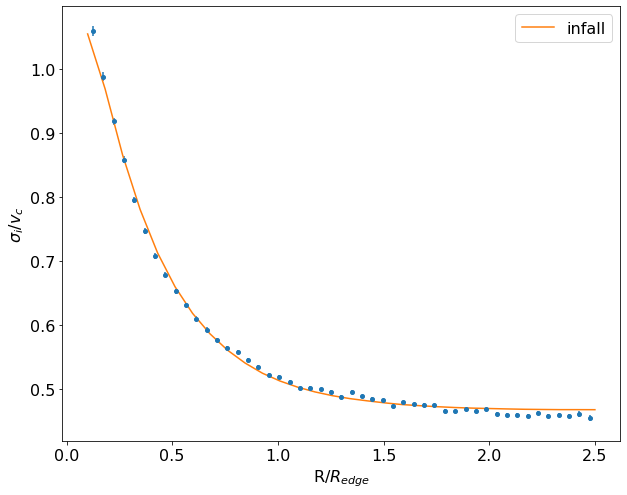

In [114]:
fig,(ax1) = plt.subplots(1, 1,figsize=(10,8))
inf=ax1.errorbar(center, sigma_inf, yerr=inf_error, fmt='o',markersize=4)

ax1.plot(radial_bins[:len(infmean)],infmean, label='infall')
ax1.legend()
ax1.set_xlabel('R/$R_{edge}$')
ax1.set_ylabel('$\sigma_i/v_c$')

# Finally, let's look at some of the bins for the fit.

In [115]:
def plot_fit(df,parameters,minr,maxr,num_resample,fig,ax1):
    
    num_data_bin_edges = 50
    num_sim_bin_edges = 251
    min_x = -6
    max_x = 6

    sim_x_vals = np.linspace(min_x, max_x, num_sim_bin_edges)
    data_x_vals = np.linspace(min_x, max_x, num_data_bin_edges)
    data_bin_centers = (data_x_vals[:-1] + data_x_vals[1:])/2.
    data_bin_width = data_bin_centers[1] - data_bin_centers[0]
    sim_bin_centers = (sim_x_vals[:-1] + sim_x_vals[1:])/2.
    sim_bin_width = sim_bin_centers[1] - sim_bin_centers[0]
    
    sp_inf,q_inf, alpha_inf, r_pinf,alpha_rinf=parameters
    
    r=df.d2d*df.hostr
    rich=df.hostm/1e14
    lambda_p = np.median(rich)
    r_edge = 2.0*df.hostr
    
    dfcut=df[ (r/r_edge>minr) & (r/r_edge <=maxr) ].copy()
    dfcut=dfcut.reset_index()

    v=dfcut.v/100
    r=dfcut.d2d*dfcut.hostr
    rich=dfcut.hostm/1e14
    r_lambda=(rich / 100.0) ** 0.2
    r_edge = 2.0*dfcut.hostr

    #define scaling sigma_v
    sigmav_lam = sp_inf*(rich/lambda_p)**alpha_inf
    sigma_v = sigmav_lam
    
    inf_v = []
    
    for i in tqdm(range(num_resample)):
        
        r_inf = r_pinf*(rich/lambda_p)**alpha_rinf
        inf_sigmav_lam = sp_inf*(rich/lambda_p)**alpha_inf
        inf_sigmav = inf_sigmav_lam*(q_inf*np.exp(-r/r_inf)+1)
        inf_v = np.append(inf_v,hypsecant.rvs(scale=inf_sigmav/np.pi*2.0)/sigma_v)
    
    inf_count, bin_edges = np.histogram(inf_v, sim_x_vals)
    inf_normalized = inf_count / len(v) / sim_bin_width / num_resample
    
    normalized_v=v/sigma_v
    
    counts, bin_edges = np.histogram(normalized_v, data_x_vals)
    normalized_counts = counts / len(v) / data_bin_width
    
    inf_lines = ax1.plot(sim_bin_centers, inf_normalized, linewidth=5, ls="dotted")
    ax1.errorbar(data_bin_centers, normalized_counts, yerr=np.sqrt(counts)/data_bin_width/len(v), fmt='o',markersize=12,linewidth=5)
    ax1.set_xlim([-8, 8])
    ax1.set_ylim([-0.01, 0.6])
    ax1.set_xlabel('$v$ / $\sigma_{v,inf}$')
    ax1.set_ylabel('P($v$ / $\sigma_{v,inf})$')
    
    inset_ax = inset_axes(ax1,
                      height="30%", # set height
                      width="30%", # and width
                      loc='upper right')
    inset_ax.axvspan(minr, maxr, alpha=0.5, color='red')
    inset_ax.set_xlim(0,2.5)
    inset_ax.set_yticks([])
    inset_ax.set_xlabel('$R/R_{edge}$')  

  0%|          | 0/30 [00:00<?, ?it/s]

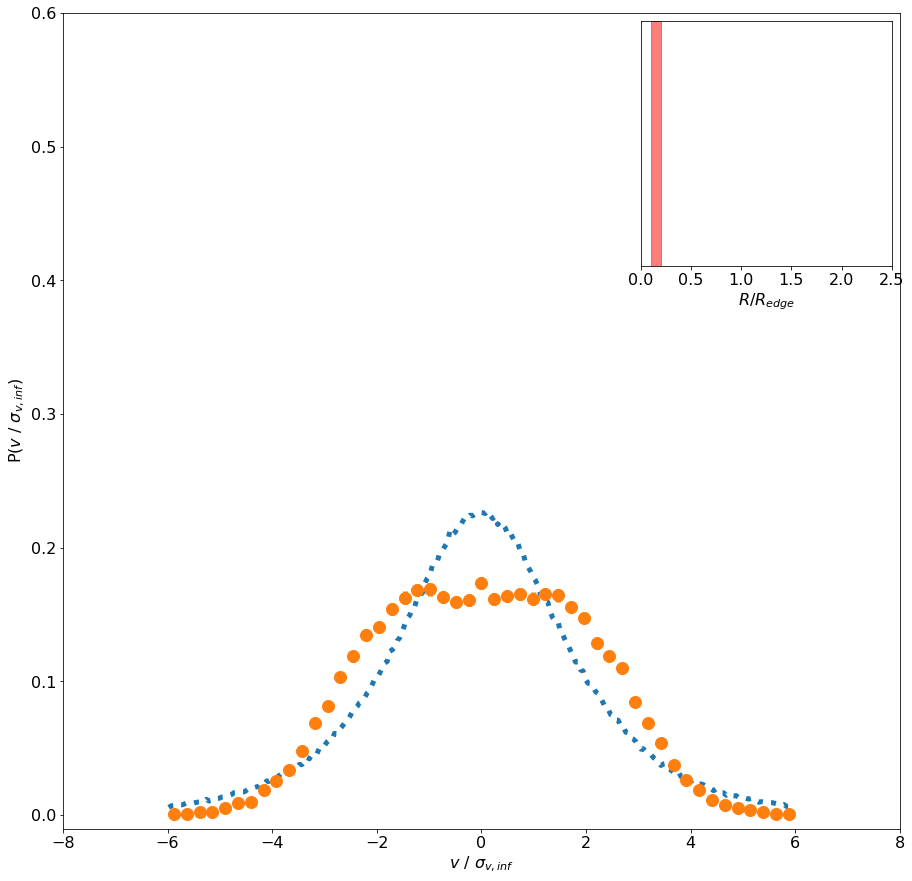

In [116]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,15))
infv=plot_fit(infall,fit.value,0.1,0.2,30,fig,ax1)

  0%|          | 0/30 [00:00<?, ?it/s]

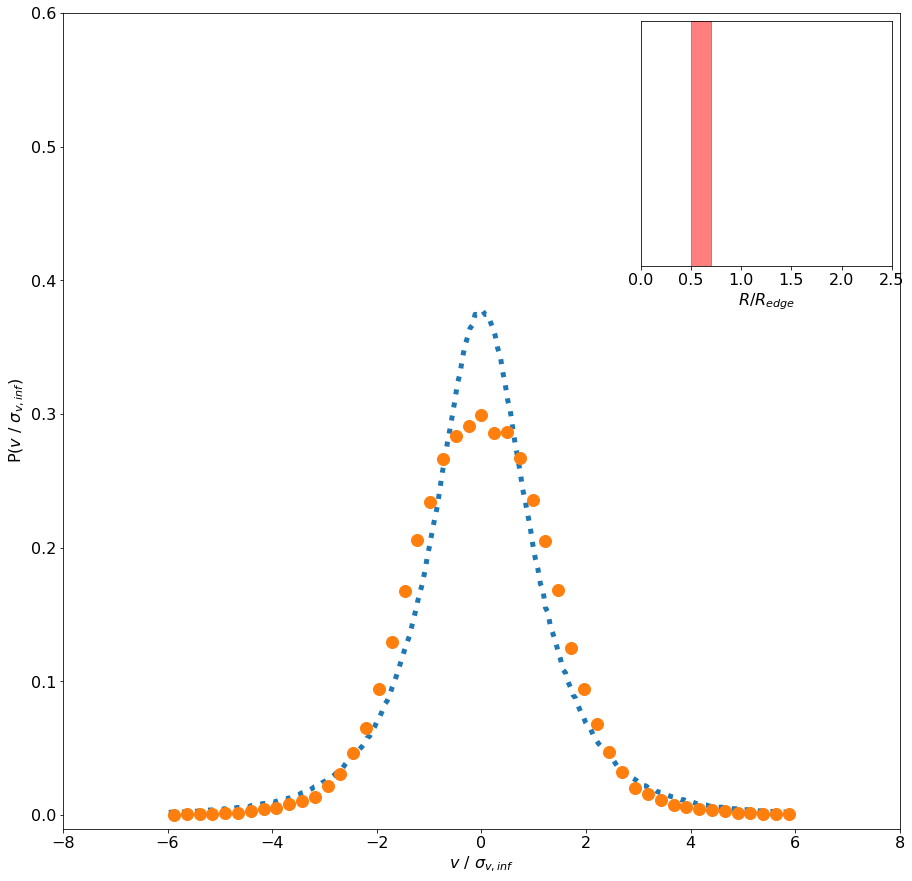

In [117]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,15))
infv=plot_fit(infall,origin,0.5,0.7,30,fig,ax1)

  0%|          | 0/30 [00:00<?, ?it/s]

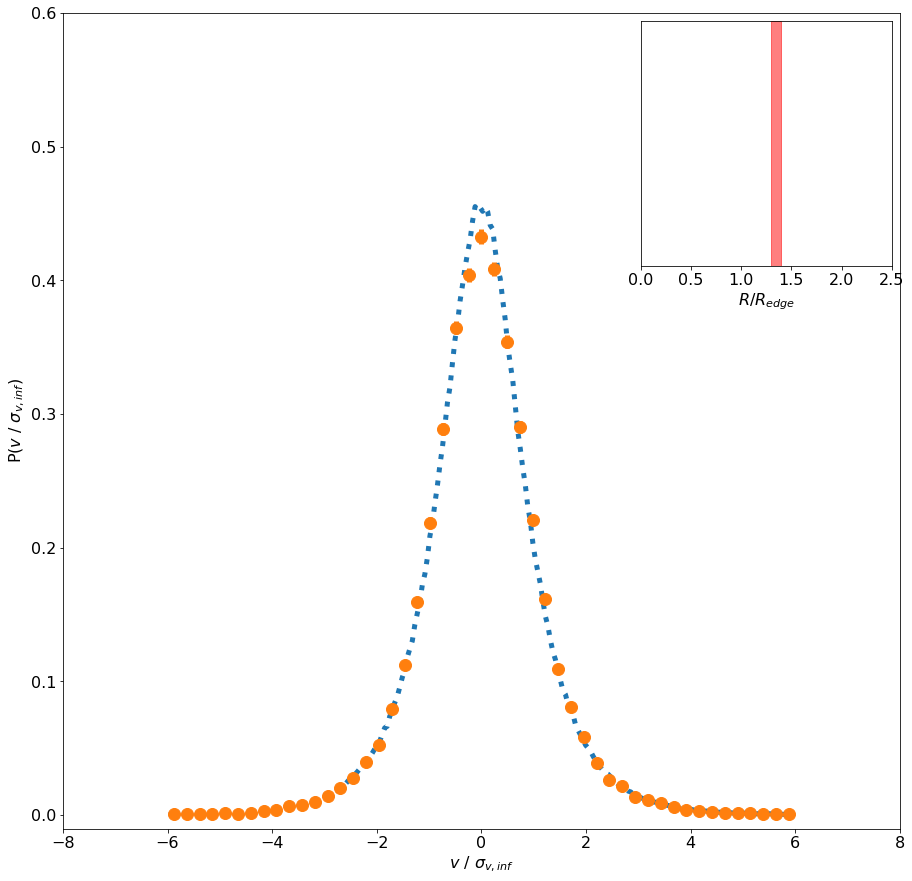

In [118]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,15))
infv=plot_fit(infall,origin,1.3,1.4,30,fig,ax1)